<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350A)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2024/2025 <br>
Assistant: Nicolas Vercheval
</div>

# Decision trees

The library `scikit-learn` offers a class for decision trees. Recall: in each node of the decision tree, excluding the leaves, we have one test that examines the criteria for splitting the tree. Each test result corresponds to one node branch leading to the next node. Over the following nodes, the described procedure is applied recursively until some of the stop criteria of model training are met. This can be the maximum depth of the tree, the minimum number of instances in the leaf, or something else.

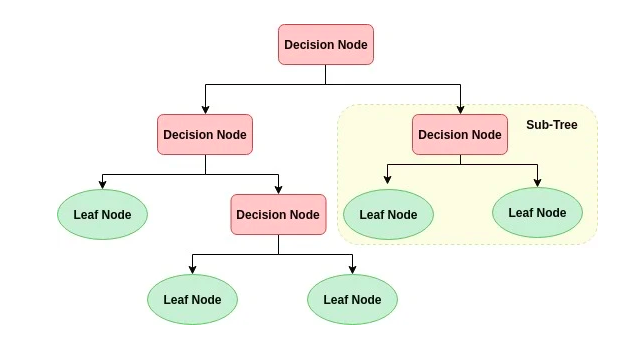

We apply decision trees to a standard classification task. We use the `Pima Indians Diabetes` dataset, which combines general medical data with cases of diabetes. The dataset and supporting information can be found at [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree

First let us load the data and let us prepare it for training and testing.

In [3]:
data = pd.read_csv(os.path.join(os.pardir, 'data', 'diabetes.csv'))

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
data.describe().T # use .T to transpose for readability

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [8]:
y = data['Outcome']

In [9]:
X = data.drop(columns=['Outcome'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

In [9]:
# This step is not necessary for trees!

# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

Inside the package `tree` of the `scikit-learn` library, you find the classes for decision networks and functions for their visualization.

### Measuring attribute importance - Homogeneity Measures
In decision tree learning, we measure the importance of each feature (attribute) among the candidates for the next split by assessing how desirable the split would be. The ideal split is where all examples are equally separated into different classes by the attribute's value. This is why in machine learning literature the term ‘homogeneity’ is used to express how appropriate a given feature is for the split, meaning how ‘homogeneous’ or ‘pure’ the subsets in the split are.
The two main measures of inhomogeneity are the entropy and the Gini impurity (also known as Gini index). The closer their values are to zero, the better we can separate the classes into regions where one class is prevalent.
The Information Gain quantifies the entropy we can reduce by selecting a feature. The more desirable the feature, the larger the gain.

#### Information Gain

The entropy is the amount of missing information or uncertainty.

The entropy for a target variable $T$ in a set $E$ with normalized frequencies $P_i, i \in \{ 1, 2, \dots, N\}$ is:

$$H(T, E) = H(<P_1, \dots, P_N>)=-\sum_{i=1}^{N}P_{i}log_{2}(P_{i}).$$

We call this also the entropy of an information source with the prior $<P_1, \dots, P_N>$. This number corresponds to the expected bits (EBS) necessary to describe the distribution of the target variable on the entire set E.

An attribute $A$ with $J$ values divides $E$ into $J$ subsets: $ \{E_j\}_{j \in \{ 1, 2, \dots, J\}}$. 

The information gain of attribute $A$ measures how much more informative the resulting partitioning of $E$ is.
The expected entropy remaining after testing the attribute $A$ is:
$$H(T, \{E_j\}_{j \in \{ 1, 2, \dots, J\}})=  \sum_j \dfrac{M_j}{M} H(T,E_j).$$

Thus the Information Gain of attribute $A$ is 
$$IG(A) = H(T, E) - H(T, \{E_j\}_{j \in \{ 1, 2, \dots, J\}}).$$

#### Gini impurity
Gini impurity measures how often a randomly chosen element of a set would be incorrectly labelled if labelled randomly and independently according to the distribution of labels in the set. It reaches its minimum (zero) when all cases in the node fall into a single target category.

Let us consider a set $E$ containing a target variable $T$ with $N$ classes and normalized frequencies $P_i, i \in \{ 1, 2, \dots, N\}$. The estimated probability of choosing an item with label $i$ is $P_i$. The probability of miscategorizing that item is $\sum_{k \neq i} P_k = 1 − P_i$. The Gini impurity is computed by summing pairwise products of these probabilities for each class label: 

$$I_{G}(T, E)= I_{G}(<P_1, \dots, P_N>)=\sum_{i=1}^{N}(P_{i}\sum_{k\ne i}P_{k})=\sum_{i=1}^{N}P_{i}(1-P_{i})=\sum_{i=1}^{N}(P_{i}-P_{i}^{2})=\sum_{i=1}^{N}P_{i}-\sum_{i=1}^{N}P_{i}^{2}=1-\sum_{i=1}^{N}P_{i}^{2}.$$

The impurity associated with a split corresponds to the average impurity for each level. Consider a split corresponding to a partition $ \{E_j\}_{j \in \{ 1, 2, \dots, J\}}$ of our current set $E$. Let us call $M$ the size of $E$ and $M_j$ the size of $E_j$. We can express the impurity of the split with:
$$I_{G}(T, \{E_j\}_{j \in \{ 1, 2, \dots, J\}})=  \sum_{j} \dfrac{M_j}{M} I_{G}(T, E_j)).$$



Let us visualise the impurity and the entropy in case of a binary target variable as a function of the frequency:

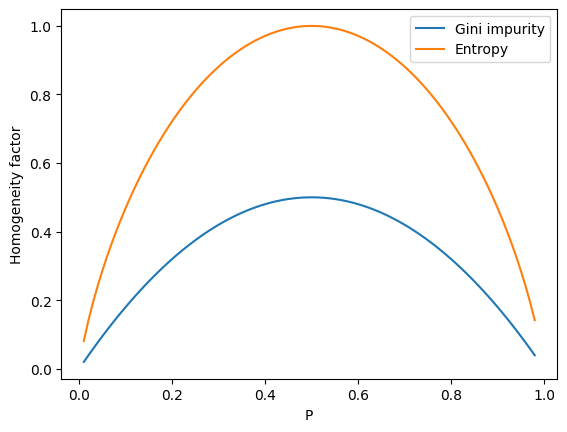

In [11]:
x = np.arange(0.01, 0.99, 0.01)

plt.xlabel("P")
plt.ylabel("Homogeneity factor")

plt.plot(x, 1 - x ** 2 - (1 - x) ** 2, label="Gini impurity")
plt.plot(x, - x * np.log2(x) - (1 - x) * np.log2(1 - x), label="Entropy")

plt.legend();

When a set is equally divided into positive and negative cases, the homogeineity factor is at the maximum for both the Gini impurity and entropy.
The Gini impurity hits the value of $0.5$, corresponding to a random guess of the set's element.
The entropy is $1$ bit because is equivalent to the definition of the unit.
We can add a factor of $2$ to the Gini impurity (which does not affect the criteria) to see the different shape:

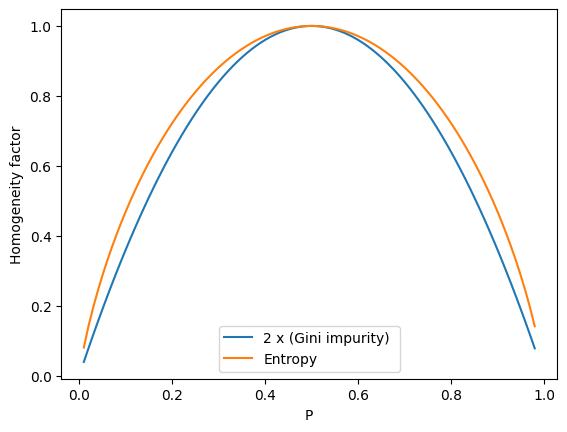

In [11]:
x = np.arange(0.01, 0.99, 0.01)

plt.xlabel("P")
plt.ylabel("Homogeneity factor")

plt.plot(x, 2 * (1 - x ** 2 - (1 - x) ** 2), label="2 x (Gini impurity) ")
plt.plot(x, - x * np.log2(x) - (1 - x) * np.log2(1 - x), label="Entropy")

plt.legend();

### Binary trees
We have seen how to evaluate a split given the distributions of the target variable. The question now is how to use attributes to propose candidate splittings for evaluation. The possible ways of splitting a set grow faster than polynomially with its size, and it may be impossible to evaluate the all. 

Let us consider a numerical attribute with $M$ unique values. We can consider a partition of a dataset based on the partition of these values. For example, if those $M=3$ elements are $\{1, 3, 4\}$, the possible partitions are 5: 

1. the trivial one $\{1, 3, 4\}$ (we can ignore this one)
2. $\{\{1\}, \{3\}, \{4\}\} $
3. $\{\{1, 3\}, \{4\}\}$
4. $\{\{1\}, \{3, 4\}\}$
5. $\{\{3\}, \{1, 4\}\}$.      

For more information about this number for a set of size $M$, the mathematically inclined among you may read the Wikipedia article about [Bell number](https://en.wikipedia.org/wiki/Bell_number)s.

Instead of considering all the possible partitions, binary trees consider a threshold mechanism (binary splitting). In the previous example, you would only consider the partitions:
1. $\{\{1, 3\}, \{4\}\}$ (threshold= $3.5$)
2. $\{\{1\}, \{3, 4\}\}$ (threshold=$2$).

This strategy drastically reduces the number of partitions that need to be evaluated (less than $M$ for each attribute), making this algorithm computationally efficient. 

In the resulting two children nodes, the same attribute is again evaluated for the next split. It is possible to recursively split the set using the same attribute and achieve a finer partition (such as  $\{\{1\}, \{3\}, \{4\}\} $ in our example). This greedy strategy is called "Recursive binary splitting".

For ordinal and binary data, recursive binary splitting works similarly.

For example, the threshold for binary data with values $\in \{0, 1\}$ is $0.5$.



#### Categorical data
Categorical data don't have an order, and using a threshold as a splitting point is no longer possible. 
One way to have a binary split is to consider the elements with one value on the one side and those without that value on the other.
This idea corresponds to translating a categorical variable into one hot encoding and performing recursive binary splitting on the resulting binary data as above.


##### One hot encoding
Given a categorical variable with nominal values, the one-hot encoding of this variable is a sequence of binary variables where, for each data point, precisely one of these variables is equal to one.
For example, if the variable Animal has possible values {"cat", "dog"}, the hot encoding for a cat will be (1, 0), corresponding to "cat=True" and "dog=False".

One hot encoding is a common strategy to deal with categorical variables because most models cannot deal with categorical variables directly.

##### Scikit-learn 
The tree package in scikit-learn implements Recursive binary splitting, specifically a version of an algorithm called CART (Classification And Regression Tree).

According to the documentation:
"scikit-learn uses an optimized version of the CART algorithm; however, the scikit-learn implementation does not support categorical variables for now".

**The package does not automatically perform the one hot conversion of categorical data. You need to do it yourself during preprocessing.**




### Implementation with scikit-learn

The library allows you to set a criterion for the type of homogeneity, the maximum tree depth, the minimum value of branch purity, the minimum number of instances per node, and many others. Set the value of the `random_state` parameter due to repeating the experiment.

In [12]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=7)

The method for training and evaluating are consistent with the other model classes from sklearn.

In [13]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=7)

In [14]:
y_predict = model.predict(X_test)

In [15]:
metrics.accuracy_score(y_test, y_predict)

0.7283464566929134

The `plot_tree` function gives an illustration of a decision tree. In each node of the tree, you can see the training statistics: the value of the homogeneity measure, the total number of samples in each node, and the number of instances by class.

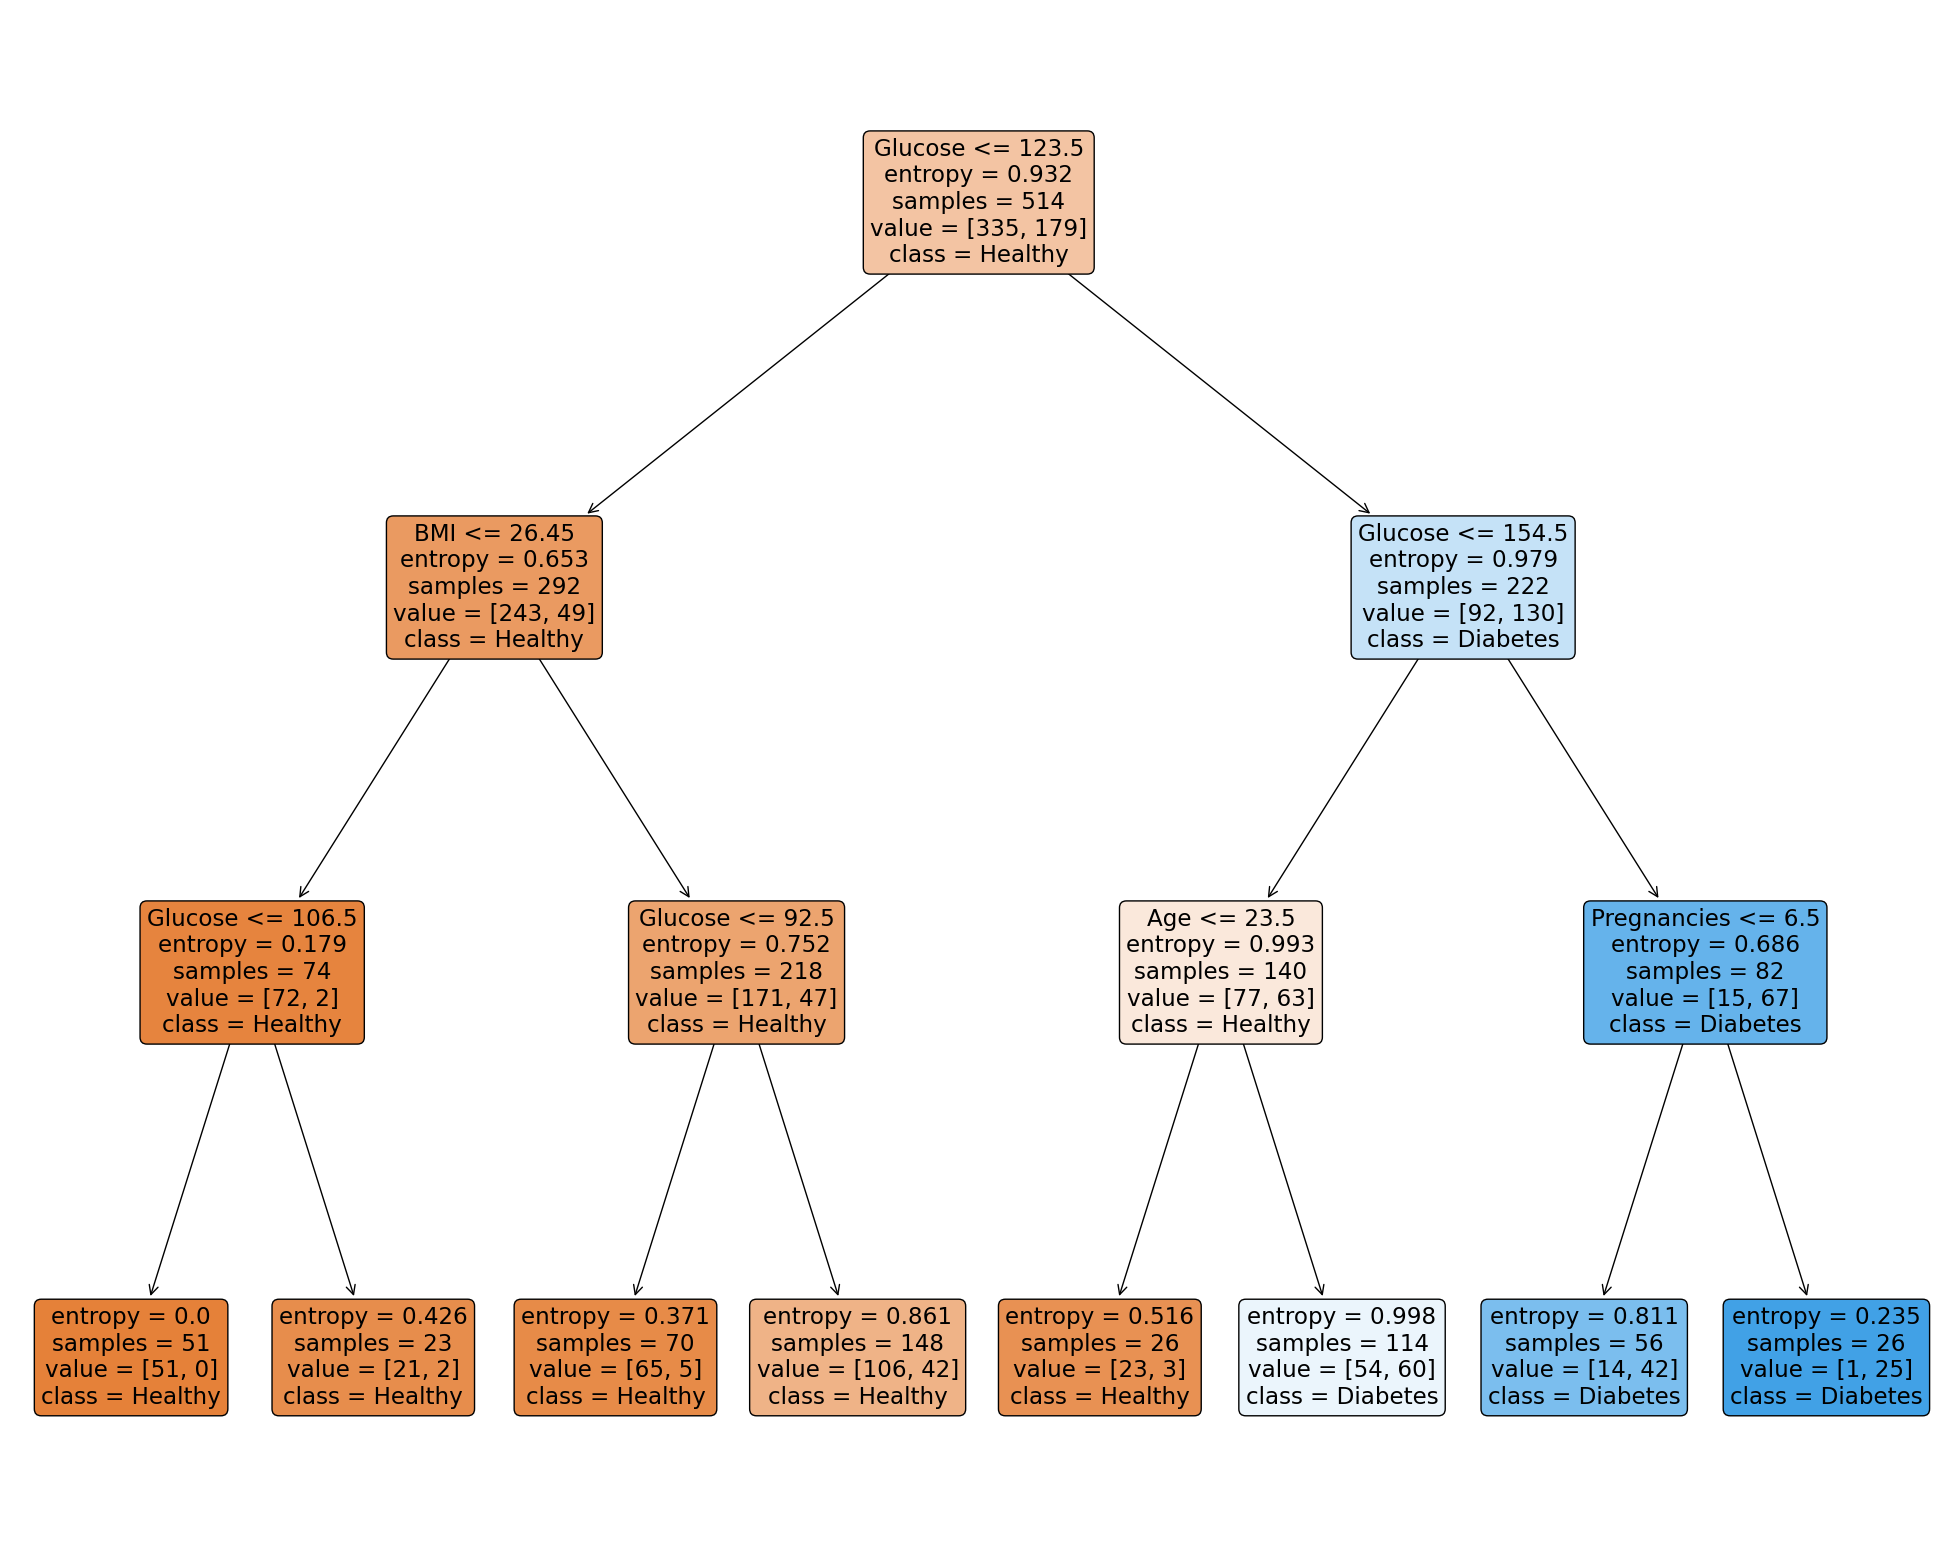

In [16]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=list(X.columns), class_names=['Healthy','Diabetes'], filled=True,  rounded=True)

The decision trees can be used to assess the importance of the attributes. The significance of the attribute depends on how much it is used in the branching process.

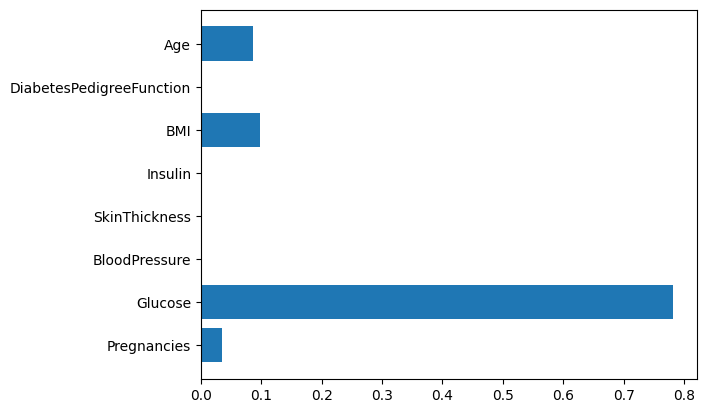

In [17]:
plt.barh(list(X.columns), model.feature_importances_)
plt.show()